In [17]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

In [18]:
protoPath = "deploy.prototxt.txt"

modelPath = "res10_300x300_ssd_iter_140000.caffemodel"

detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

embedder = cv2.dnn.readNetFromTorch("openface.nn4.small2.v1.t7")

In [19]:
import os
imagePaths = []
main_dir = "train_images"
main_dir_list = os.listdir(main_dir)
for name in main_dir_list:
    name_dir = os.path.sep.join([main_dir, name])
    name_dir_list = os.listdir(name_dir)
    for image in name_dir_list:
        imagePath = os.path.sep.join([main_dir, name, image])
        imagePaths.append(imagePath)


In [20]:
imagePaths

['train_images\\dhoni\\dhoni.jpg',
 'train_images\\dhoni\\dhoni2.jpeg',
 'train_images\\dhoni\\dhoni3.jpeg',
 'train_images\\dhoni\\dhoni4.jpeg',
 'train_images\\dhoni\\dhoni6.jpeg',
 'train_images\\jasprit bumrah\\bumrah1.jpeg',
 'train_images\\jasprit bumrah\\bumrah2.jpeg',
 'train_images\\jasprit bumrah\\bumrah4.jpeg',
 'train_images\\jasprit bumrah\\bumrah6.jpeg',
 'train_images\\jasprit bumrah\\jaspritbumrah.jpeg',
 'train_images\\kl rahul\\kl rahul 4.jpeg',
 'train_images\\kl rahul\\kl rahul.jpeg',
 'train_images\\kl rahul\\rahul3.jpeg',
 'train_images\\kl rahul\\rahul4.jpeg',
 'train_images\\kl rahul\\rahul5.jpeg',
 'train_images\\kohli\\kohli.jpeg',
 'train_images\\kohli\\kohli2.jpeg',
 'train_images\\kohli\\kohli3.jpeg',
 'train_images\\kohli\\kohli5.jpeg',
 'train_images\\kohli\\kohli6.jpeg',
 'train_images\\suresh raina\\raina 1.jpeg',
 'train_images\\suresh raina\\raina.jpeg',
 'train_images\\suresh raina\\suresh raina.jpeg']

In [21]:
for i in imagePaths:
    print(i.split(os.path.sep)[-2], " : ",i)
    print()

dhoni  :  train_images\dhoni\dhoni.jpg

dhoni  :  train_images\dhoni\dhoni2.jpeg

dhoni  :  train_images\dhoni\dhoni3.jpeg

dhoni  :  train_images\dhoni\dhoni4.jpeg

dhoni  :  train_images\dhoni\dhoni6.jpeg

jasprit bumrah  :  train_images\jasprit bumrah\bumrah1.jpeg

jasprit bumrah  :  train_images\jasprit bumrah\bumrah2.jpeg

jasprit bumrah  :  train_images\jasprit bumrah\bumrah4.jpeg

jasprit bumrah  :  train_images\jasprit bumrah\bumrah6.jpeg

jasprit bumrah  :  train_images\jasprit bumrah\jaspritbumrah.jpeg

kl rahul  :  train_images\kl rahul\kl rahul 4.jpeg

kl rahul  :  train_images\kl rahul\kl rahul.jpeg

kl rahul  :  train_images\kl rahul\rahul3.jpeg

kl rahul  :  train_images\kl rahul\rahul4.jpeg

kl rahul  :  train_images\kl rahul\rahul5.jpeg

kohli  :  train_images\kohli\kohli.jpeg

kohli  :  train_images\kohli\kohli2.jpeg

kohli  :  train_images\kohli\kohli3.jpeg

kohli  :  train_images\kohli\kohli5.jpeg

kohli  :  train_images\kohli\kohli6.jpeg

suresh raina  :  train_ima

In [22]:
knownEmbeddings = []
knownNames = []

total = 0
i = 0

In [23]:
for i in range(len(imagePaths)):
    
    imagePath = imagePaths[i]
    
    print("[INFO] processing image {}/{}".format(i + 1, len(imagePaths)))
    name = imagePath.split(os.path.sep)[-2]
    
  
    
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    
    
    imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0),
                                      swapRB=False, crop=False)
  
    
    detector.setInput(imageBlob)
    detections = detector.forward()
    
    if len(detections) > 0:
        
       
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]
        
        
        
        if confidence > 0.5:
        
        
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
           
            face = image[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]

            if fW < 20 or fH < 20:
                continue
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96), (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()
            knownNames.append(name)
            knownEmbeddings.append(vec.flatten())
            total += 1

[INFO] processing image 1/23
[INFO] processing image 2/23
[INFO] processing image 3/23
[INFO] processing image 4/23
[INFO] processing image 5/23
[INFO] processing image 6/23
[INFO] processing image 7/23
[INFO] processing image 8/23
[INFO] processing image 9/23
[INFO] processing image 10/23
[INFO] processing image 11/23
[INFO] processing image 12/23
[INFO] processing image 13/23
[INFO] processing image 14/23
[INFO] processing image 15/23
[INFO] processing image 16/23
[INFO] processing image 17/23
[INFO] processing image 18/23
[INFO] processing image 19/23
[INFO] processing image 20/23
[INFO] processing image 21/23
[INFO] processing image 22/23
[INFO] processing image 23/23


In [24]:
data = {"embeddings": knownEmbeddings, "names": knownNames}
f = open('Trined_Embeddings', "wb")
f.write(pickle.dumps(data))
f.close()

In [25]:
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pickle
from sklearn.preprocessing import LabelEncoder

In [26]:
model = Sequential([Dense(128, input_shape = (128,), activation = 'relu'),
                    Dense(64, activation = 'relu', kernel_initializer = 'he_uniform'),
                    Dense(64, activation = 'relu',  kernel_initializer = 'he_uniform'),
                    Dense(32, activation = 'relu',  kernel_initializer = 'he_uniform'),
                    Dense(32, activation = 'relu',  kernel_initializer = 'he_uniform'),
                    Dense(5, activation = 'softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam' ,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 32,229
Trainable params: 32,229
Non-trai

In [27]:
data = pickle.loads(open('Trined_Embeddings', "rb").read())

le = LabelEncoder()
labels = le.fit_transform(data["names"])

In [28]:
embeddings = data["embeddings"]
embeddings = np.array(embeddings)

In [29]:
h = model.fit(embeddings, labels, epochs = 50)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.6096 - accuracy: 0.0870
Epoch 2/50
1/1 [==============================] - 0s 8ms/step - loss: 1.5938 - accuracy: 0.3913
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 1.5796 - accuracy: 0.4783
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 1.5672 - accuracy: 0.5217
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 1.5541 - accuracy: 0.6087
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 1.5400 - accuracy: 0.6522
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 1.5237 - accuracy: 0.6522
Epoch 8/50
1/1 [==============================] - 0s 8ms/step - loss: 1.5057 - accuracy: 0.6087
Epoch 9/50
1/1 [==============================] - 0s 8ms/step - loss: 1.4865 - accuracy: 0.6522
Epoch 10/50
1/1 [==============================] - 0s 0s/step - loss: 1.4666 - accuracy: 0.6522
Epoch 11/50
1/1 [========================

In [30]:
model.save('recognizer.h5')
f = open("label_Encoder", "wb")
f.write(pickle.dumps(le))
f.close()

In [31]:
from keras.models import load_model

In [33]:
protoPath = "deploy.prototxt.txt"

modelPath = "res10_300x300_ssd_iter_140000.caffemodel"

detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

embedder = cv2.dnn.readNetFromTorch("openface.nn4.small2.v1.t7")
recognizer = load_model('recognizer.h5')

le = pickle.loads(open("label_Encoder", "rb").read())


In [34]:
def image_recognize(image):
    image = cv2.resize(image, (1240, 480))
    (h, w) = image.shape[:2]
    imageBlob = cv2.dnn.blobFromImage( cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0), 
                                      swapRB=False, crop=False)
    
    detector.setInput(imageBlob)
    detections = detector.forward()
    
    for i in range(0, detections.shape[2]):
    
        confidence = detections[0, 0, i, 2]

        if confidence > 0.85:
        
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            face = image[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]

          
            if fW < 30 or fH < 30:
                continue
                
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96), (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()

           
            preds = recognizer.predict(vec)[0]
            j = np.argmax(preds)

            proba = preds[j]
            name = le.classes_[j]
            if proba >= 0.40:
                text = name

                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
                cv2.putText(image, text, (startX, startY), cv2.FONT_HERSHEY_DUPLEX, 1.2, (0, 255, 0), 2)

    return np.array(image)

In [35]:
import os
imagePaths = []
main_dir = "test_images"
main_dir_list = os.listdir(main_dir)

for image in main_dir_list:
        imagePath = os.path.sep.join([main_dir, image])
        imagePaths.append(imagePath)
print(imagePaths)

['test_images\\person1.jpeg', 'test_images\\person2.jpeg', 'test_images\\person3.jpeg', 'test_images\\person4.jpeg', 'test_images\\person5.jpeg']


1/1 [==============================] - 0s 16ms/step


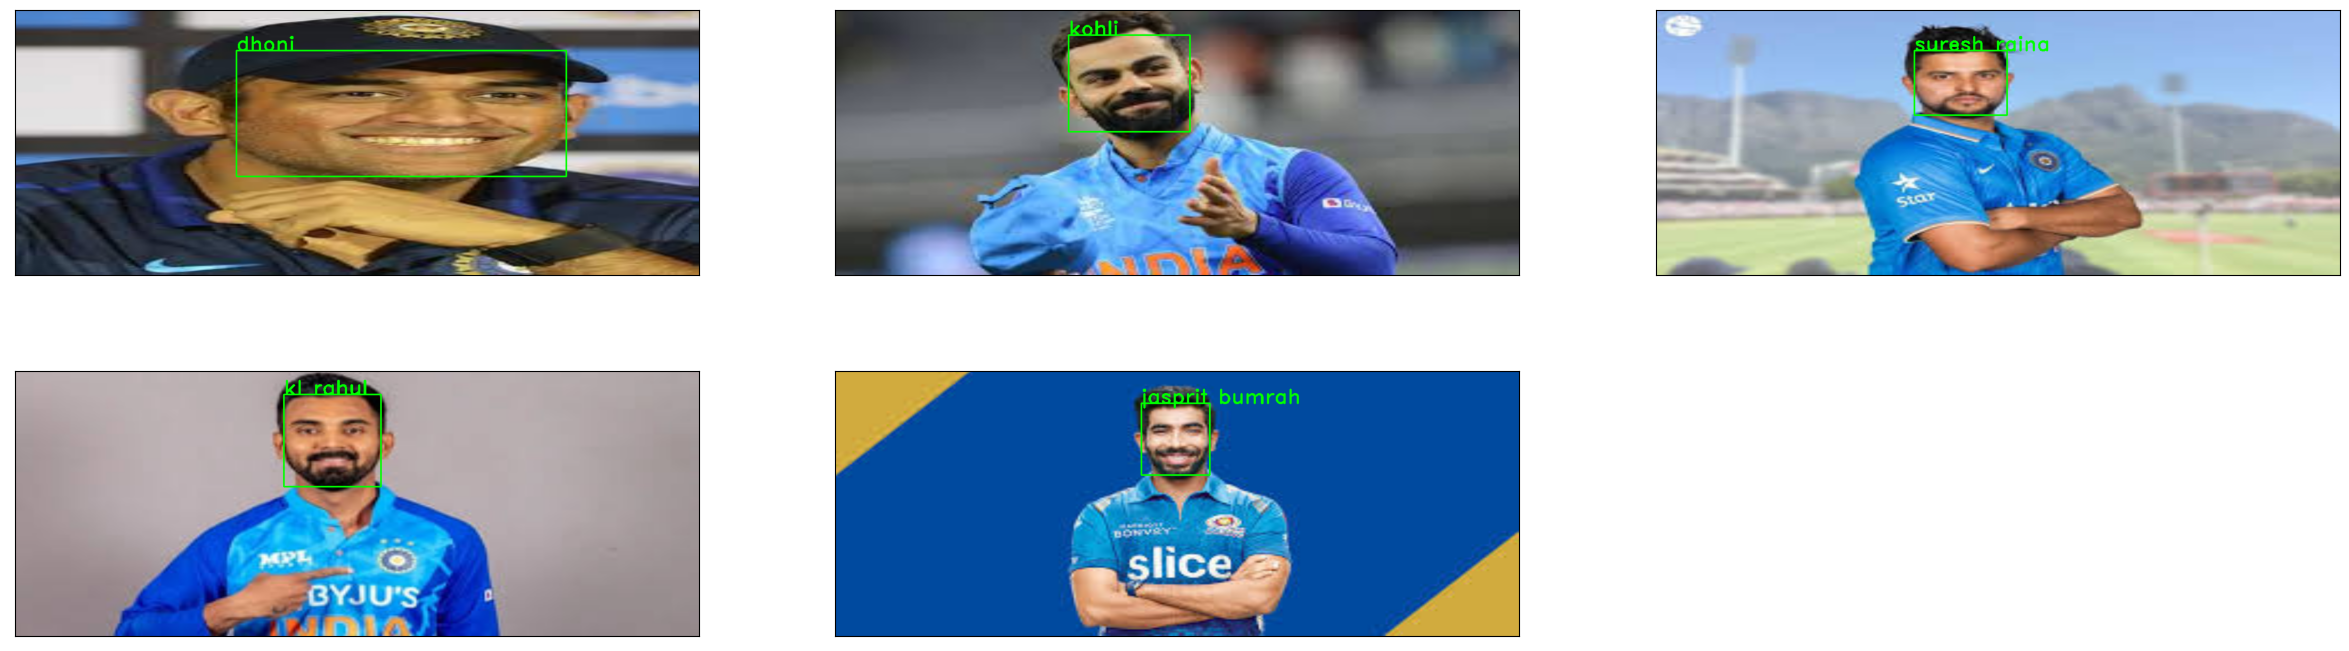

In [37]:
c = 1
fig = plt.figure(figsize = (30,18)) 
for i in imagePaths:
    image = cv2.imread(i)
    image= image_recognize(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig.add_subplot(4,3,c)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    c += 1
plt.show()